# Part One: True Ensemble Method

The first section of this notebook looks at true ensemble methods where the base models are trained along side the ensemble model. Because of the nature of this process, we are only looking at the models regarding title and one description model due to the nature of training the neural net and LSTM.

In [2]:
import csv
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#----------------- EVERY IMPORT STATEMENT WE COULD POSSIBLY WANT -----------------#

import six
import sys

import sklearn.externals as extjoblib
import joblib

sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import gzip
import pickle
import nltk
import re
import tensorflow as tf

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping as ES
from keras.callbacks import ModelCheckpoint as MC
from keras.callbacks import TensorBoard as TB
from keras.layers import Dropout

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from keras.preprocessing.text import Tokenizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Preprocessing
First we need to preprocess the data the same way that it was done in the title and description notebooks. 


In [ ]:

#----------------- SET UP DRIVE AND GET DATA -----------------#

# Load from Google Drive
drive.mount('/content/gdrive')

# Load the full data 
all_data = pd.read_csv('gdrive/MyDrive/books_clean.csv.gz', compression='gzip')


Mounted at /content/gdrive


In [ ]:
title_description_df = all_data.copy()

In [ ]:
# Filter for only rows that have titles and get rid of commas and things that will mess with titles
title_description_df = title_description_df[title_description_df['title'] == title_description_df['title']]
title_description_df['title'] = title_description_df['title'].str.replace(',','')
title_description_df['title'] = title_description_df['title'].str.replace('\'','')

In [ ]:
# Filter for only rows that have descriptions and get rid of ones whos description length is too short to be helpful or one of the five generic descriptions
title_description_df = title_description_df[title_description_df['description'] == title_description_df['description']]
top_10_desc = title_description_df['description'].value_counts()[:10].index.tolist()
title_description_df = title_description_df.loc[title_description_df['description'].isin(top_10_desc[:5])==False]
title_description_df.drop(title_description_df[title_description_df.description.str.len() < 10].index, inplace=True)


This leaves us with 1,231,824 records on which we can train.  Lets preprocess each column and make a new dataframe.

First we will get the titles into a vectorized form that we can train on.


## Ensemble Method Experimentation

The following subtitles are in the order "description", "title"



### ENSEMBLE 1: CountVectorizer + NB, TDIF + LR

In [ ]:
title_description_df = title_description_df[['book_id', 'title','description','first']]
title_description_df.head(2)

,book_id,title,description,first
1,1333909,Good Harbor,"Anita Diamant's international bestseller ""The ...",fiction
2,7327624,The Unschooled Wizard (Sun Wolf and Starhawk #...,Omnibus book club edition containing the Ladie...,"fantasy, paranormal"


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(title_description_df[['title','description']], title_description_df['first'], test_size=0.3, random_state=42)

In [ ]:
pipeline1 = Pipeline(
    [
        ("select", ColumnSelector(cols=('description'),drop_axis=True)),
        ("vect", CountVectorizer(analyzer = 'word',ngram_range=(1,1), stop_words='english')),
        ("nb", MultinomialNB())
    ]
)
pipeline2 = Pipeline(
    [
        ("select2", ColumnSelector(cols=('title'),drop_axis=True)),
        ("vect2", TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=5, sublinear_tf=True)),
        ("log", LogisticRegression(solver='sag',max_iter=200))
    ]
)
eclf = EnsembleVoteClassifier(clfs=[pipeline1, pipeline2], voting ='soft')


In [ ]:
eclf.fit(X_train, y_train)

EnsembleVoteClassifier(clfs=[Pipeline(steps=[('select',
                                              ColumnSelector(cols='description',
                                                             drop_axis=True)),
                                             ('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('nb', MultinomialNB())]),
                             Pipeline(steps=[('select2',
                                              ColumnSelector(cols='title',
                                                             drop_axis=True)),
                                             ('vect2',
                                              TfidfVectorizer(min_df=5,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words='eng

In [ ]:
train_pred = eclf.predict(X_train)
f1_score(y_train, train_pred, average='micro')


0.7510576659909356

In [ ]:
test_pred = eclf.predict(X_test)
f1_score(y_test, test_pred, average='micro')

0.7246474071027308

In [ ]:
print(metrics.classification_report(y_test, test_pred))

                                        precision    recall  f1-score   support

                              children       0.77      0.74      0.76     23995
                       comics, graphic       0.86      0.57      0.69     14085
                   fantasy, paranormal       0.71      0.75      0.73     43738
                               fiction       0.69      0.67      0.68     76246
history, historical fiction, biography       0.61      0.62      0.62     33700
              mystery, thriller, crime       0.75      0.80      0.78     37329
                           non-fiction       0.81      0.76      0.78     65419
                                poetry       0.85      0.63      0.72      6970
                               romance       0.69      0.88      0.77     56967
                           young-adult       0.70      0.28      0.40     11099

                              accuracy                           0.72    369548
                             macro avg

### ENSEMBLE 2: TDIDF + NB, TDIDF + LR

In [ ]:
pipeline3 = Pipeline(
    [
        ("select", ColumnSelector(cols=('description'),drop_axis=True)),
        ("vect", TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=5, sublinear_tf=True)),
        ("nb", MultinomialNB())
    ]
)
pipeline4 = Pipeline(
    [
        ("select2", ColumnSelector(cols=('title'),drop_axis=True)),
        ("vect2", TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=5, sublinear_tf=True)),
        ("log", LogisticRegression(solver='sag',max_iter=200))
    ]
)
eclf2 = EnsembleVoteClassifier(clfs=[pipeline3, pipeline4])


In [ ]:
eclf2.fit(X_train, y_train)


EnsembleVoteClassifier(clfs=[Pipeline(steps=[('select',
                                              ColumnSelector(cols='description',
                                                             drop_axis=True)),
                                             ('vect', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                             Pipeline(steps=[('select2',
                                              ColumnSelector(cols='title',
                                                             drop_axis=True)),
                                             ('vect2', TfidfVectorizer()),
                                             ('log',
                                              LogisticRegression(max_iter=200,
                                                                 solver='sag'))])])

In [ ]:
train_pred2 = eclf2.predict(X_train)
f1_score(y_train, train_pred2, average='micro')


0.6375557246171759

In [ ]:
test_pred2 = eclf2.predict(X_test)
f1_score(y_test, test_pred2, average='micro')

0.6036482405533246

In [ ]:
print(metrics.classification_report(y_test, test_pred2))

                                        precision    recall  f1-score   support

                              children       0.63      0.56      0.60     23995
                       comics, graphic       0.80      0.59      0.68     14085
                   fantasy, paranormal       0.66      0.72      0.68     43738
                               fiction       0.42      0.84      0.56     76246
history, historical fiction, biography       0.72      0.34      0.46     33700
              mystery, thriller, crime       0.75      0.36      0.49     37329
                           non-fiction       0.77      0.69      0.73     65419
                                poetry       0.43      0.00      0.01      6970
                               romance       0.79      0.64      0.71     56967
                           young-adult       1.00      0.00      0.00     11099

                              accuracy                           0.60    369548
                             macro avg

In [ ]:
filename = 'ensemble_original_73.sav'
pickle.dump(eclf, open(filename, 'wb'))

### ENEMBLE 3: TFIDF + LR, TFIDF + LR

In [ ]:
pipeline5 = Pipeline(
    [
        ("select", ColumnSelector(cols=('description'),drop_axis=True)),
        ("vect", TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=5, sublinear_tf=True)),
        ("log_d", LogisticRegression(solver='sag',max_iter=200))
    ]
)
pipeline6 = Pipeline(
    [
        ("select2", ColumnSelector(cols=('title'),drop_axis=True)),
        ("vect2", TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=5, sublinear_tf=True)),
        ("log", LogisticRegression(solver='sag',max_iter=200))
    ]
)
eclf3 = EnsembleVoteClassifier(clfs=[pipeline5, pipeline6])
eclf3.fit(X_train, y_train)
train_pred3 = eclf3.predict(X_train)
print("F1 Train: ", f1_score(y_train, train_pred3, average='micro'))
test_pred3 = eclf3.predict(X_test)
print("F1 Test: ", f1_score(y_test, test_pred3, average='micro'))
print(metrics.classification_report(y_test, test_pred3))

F1 Train:  0.7791101689018365
F1 Test:  0.714702826155195
                                        precision    recall  f1-score   support

                              children       0.65      0.85      0.74     23995
                       comics, graphic       0.82      0.77      0.79     14085
                   fantasy, paranormal       0.68      0.86      0.76     43738
                               fiction       0.58      0.81      0.68     76246
history, historical fiction, biography       0.71      0.58      0.64     33700
              mystery, thriller, crime       0.80      0.65      0.72     37329
                           non-fiction       0.83      0.73      0.78     65419
                                poetry       0.95      0.38      0.54      6970
                               romance       0.87      0.65      0.74     56967
                           young-adult       0.96      0.18      0.30     11099

                              accuracy                      

In [ ]:
filename = 'ensemble_tfidf_lr_71.sav'
pickle.dump(eclf3, open(filename, 'wb'))

### ENSEMBLE 4: CountVectorizer + NB, TDIDF + LR W/ OVERSAMPLING


In [ ]:
class_size = dict(Counter(title_description_df['first']))

In [ ]:
max_val = max(class_size.values())
oversampling_list = []

for i in title_description_df['first'].unique():
  oversampling_list.extend(title_description_df[title_description_df['first'] == i].sample(max_val, replace=True)['book_id'])

df_over = pd.DataFrame({'book_id':oversampling_list})
df_over = df_over.merge(title_description_df, on='book_id', how='left')

In [ ]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(df_over[['title','description']], df_over['first'], test_size=0.3, random_state=42)

In [ ]:
eclf.fit(X_train_o, y_train_o)

EnsembleVoteClassifier(clfs=[Pipeline(steps=[('select',
                                              ColumnSelector(cols='description',
                                                             drop_axis=True)),
                                             ('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('nb', MultinomialNB())]),
                             Pipeline(steps=[('select2',
                                              ColumnSelector(cols='title',
                                                             drop_axis=True)),
                                             ('vect2',
                                              TfidfVectorizer(min_df=5,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words='eng

In [ ]:
train_pred_o = eclf.predict(X_train_o)
f1_score(y_train_o, train_pred_o, average='micro')

0.7952478490580449

In [ ]:
f1_score(y_train_o, train_pred_o, average='macro')

0.7937987265704436

In [ ]:
test_pred_o1 = eclf.predict(X_test)
f1_score(y_test, test_pred_o1, average='macro')

0.7252642269833651

In [ ]:
print(metrics.classification_report(y_test, test_pred_o1))

                                        precision    recall  f1-score   support

                              children       0.74      0.84      0.79     23995
                       comics, graphic       0.76      0.81      0.78     14085
                   fantasy, paranormal       0.77      0.76      0.76     43738
                               fiction       0.81      0.57      0.67     76246
history, historical fiction, biography       0.62      0.70      0.65     33700
              mystery, thriller, crime       0.76      0.85      0.80     37329
                           non-fiction       0.87      0.71      0.78     65419
                                poetry       0.48      0.93      0.63      6970
                               romance       0.77      0.86      0.81     56967
                           young-adult       0.45      0.82      0.58     11099

                              accuracy                           0.74    369548
                             macro avg

## Save Model

In [ ]:
filename = 'ensemble_over_orig.sav'
pickle.dump(eclf, open(filename, 'wb'))

In [ ]:
all_pred_data = eclf.predict(title_description_df[['title','description']])

In [ ]:
title_description_df['book_id'].nunique()

1231824

In [ ]:
df_final = pd.DataFrame(list(zip(title_description_df['book_id'], all_pred_data, title_description_df['first'])),
               columns =['bid', 'ensemble_predictions', 'true_genre'])
df_final.to_csv('gdrive/MyDrive/Final_Data/all_laura_ensemble_pred.csv')

# Part Two: Ensemble With Model Predictions

This next section explores using the 5 base models to predict on the entire dataset and then training another model to create predictions that combine them all together. In the following models, the 5 base models used are: 
1.  TF-IDF + Naive Bayes on title data
2.  TF-IDF + Logistic Regression on title data
3.  Word Embeddings + LSTM on description data
4.  Word Embeddings + Naive Bayes on description data
5.  Neural Net on Book Cover data

## Combine and Clean Data
The first step in to combine the predictions into one dataframe using book_id as the unique identifier. 

### Book Descriptions
Clean the predictions created by the two book description models

In [74]:
book_desc_pred = pd.read_csv('gdrive/MyDrive/Grad School/Spring 2022/CIS 519/CIS 519 Project/Final_Data/book_description_predictions.csv')

In [75]:
genre_encoding_lookup_df = book_desc_pred[['true_label', 'true_genre']].drop_duplicates()

In [76]:
book_desc_pred2 = pd.read_csv('gdrive/MyDrive/Grad School/Spring 2022/CIS 519/CIS 519 Project/Final_Data/all_nb_desc_final_predictions.csv')


In [77]:
all_desc = book_desc_pred.merge(book_desc_pred2, on='bid', how='outer')
all_desc = all_desc[['bid', 'lstm_predictions', 'nb_predictions']]
all_desc = all_desc.merge(genre_encoding_lookup_df, left_on='nb_predictions', right_on='true_genre')
all_desc = all_desc[['bid', 'lstm_predictions', 'true_label']]
all_desc = all_desc.rename(columns={'true_label': 'nb_desc_predictions'})
all_desc.head()

,bid,lstm_predictions,nb_desc_predictions
0,1333909,4,3
1,89375,6,3
2,3209316,4,3
3,4541271,2,3
4,3209319,4,3


### Book Titles
Clean the predictions created by the two book title models

In [78]:
book_title_pred = pd.read_csv('gdrive/MyDrive/Grad School/Spring 2022/CIS 519/CIS 519 Project/Final_Data/book_title_predictions.csv')

In [79]:
book_title_pred = book_title_pred.merge(genre_encoding_lookup_df, left_on='first', right_on='true_genre')
book_title_pred = book_title_pred.merge(genre_encoding_lookup_df, left_on='NB Predictions', right_on='true_genre')
book_title_pred = book_title_pred.merge(genre_encoding_lookup_df, left_on='LogReg Predictions', right_on='true_genre')

In [80]:
book_title_pred = book_title_pred.rename(columns={'true_label_x': 'true_label1', 'true_label_y': 'nb_pred', 'true_label': 'logreg_pred'})
book_title_pred = book_title_pred.drop(columns=['true_genre_x', 'true_genre_y', 'true_genre'])

In [81]:
merged_title_desc = all_desc.merge(book_title_pred, right_on='book_id', left_on='bid', how='right')
merged_title_desc = merged_title_desc.drop(columns=['title', 'bid', 'NB Predictions', 'LogReg Predictions'])

In [82]:
merged_title_desc['nb_pred'] = merged_title_desc['nb_pred'].astype(np.float64) 
merged_title_desc['logreg_pred'] = merged_title_desc['logreg_pred'].astype(np.float64) 

In [83]:
merged_title_desc = merged_title_desc.drop(columns=['Unnamed: 0'])

merged_title_desc.head()

,lstm_predictions,nb_desc_predictions,book_id,first,true_label1,nb_pred,logreg_pred
0,NaN,NaN,5333265,"history, historical fiction, biography",4,4.0,4.0
1,4.0,5.0,6066814,"history, historical fiction, biography",4,4.0,4.0
2,4.0,4.0,13707894,"history, historical fiction, biography",4,4.0,4.0
3,NaN,NaN,6395321,"history, historical fiction, biography",4,4.0,4.0
4,NaN,NaN,18355356,"history, historical fiction, biography",4,4.0,4.0


### Book Covers
Clean the predictions created by the book covers model

In [84]:
cover_df = pd.read_csv('gdrive/MyDrive/Grad School/Spring 2022/CIS 519/CIS 519 Project/Final_Data/book_cover_predictions.csv')

In [85]:
cover_df = cover_df[['book_id', 'predictions']]
cover_df = cover_df.merge(genre_encoding_lookup_df, left_on='predictions', right_on='true_genre')
cover_df = cover_df[['book_id', 'true_label']]
cover_df = cover_df.rename(columns={'true_label': 'cover_pred'})
cover_df['cover_pred'] = cover_df['cover_pred'].astype(np.float64) 

In [86]:
merged_all = merged_title_desc.merge(cover_df, on='book_id', how='left')
merged_all.head()

,lstm_predictions,nb_desc_predictions,book_id,first,true_label1,nb_pred,logreg_pred,cover_pred
0,NaN,NaN,5333265,"history, historical fiction, biography",4,4.0,4.0,4.0
1,4.0,5.0,6066814,"history, historical fiction, biography",4,4.0,4.0,5.0
2,4.0,4.0,13707894,"history, historical fiction, biography",4,4.0,4.0,4.0
3,NaN,NaN,6395321,"history, historical fiction, biography",4,4.0,4.0,NaN
4,NaN,NaN,18355356,"history, historical fiction, biography",4,4.0,4.0,4.0


## Exploring and Comparing Predictions

First, we're going to look at the predictions as they apply to the entire dataset.

- 100% of the data has title-based predictions
- 85% of the data has description-based predictions
- 21% of the data has cover-based predictions
- 20% of the data has all three

Before we start training the model, lets take a look at what the model could do in a best case scenario. After all, if the correct genre wasn't guessed in any of the 5 models, it would be impossible for the ensemble to get it right.


In [200]:
# percent of books where the correct label is equal to one of the predictions
len(merged_all[(merged_all['true_label1'] == merged_all['nb_desc_predictions']) |
               (merged_all['true_label1'] == merged_all['lstm_predictions']) |
               (merged_all['true_label1'] == merged_all['nb_pred']) |
               (merged_all['true_label1'] == merged_all['logreg_pred']) |
               (merged_all['true_label1'] == merged_all['cover_pred'])])/len(merged_all)



0.8927947909918417

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

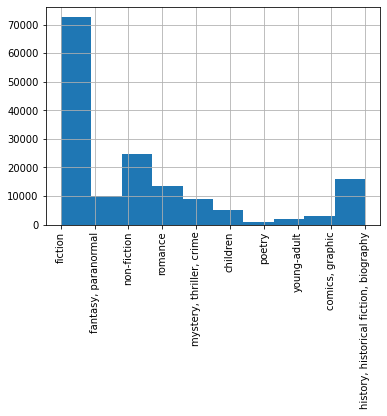

In [201]:
# percent of books where the correct label is equal to one of the predictions
merged_all[(merged_all['true_label1'] != merged_all['nb_desc_predictions']) &
           (merged_all['true_label1'] != merged_all['lstm_predictions']) &
           (merged_all['true_label1'] != merged_all['nb_pred']) &
           (merged_all['true_label1'] != merged_all['logreg_pred']) &
           (merged_all['true_label1'] != merged_all['cover_pred'])]['first'].hist()
plt.xticks(rotation=90)


In [238]:
percent_all_corr = len(merged_all[(merged_all['true_label1'] == merged_all['nb_desc_predictions']) &
                                  (merged_all['true_label1'] == merged_all['lstm_predictions']) &
                                  (merged_all['true_label1'] == merged_all['nb_pred']) & 
                                  (merged_all['true_label1'] == merged_all['logreg_pred']) & 
                                  (merged_all['true_label1'] == merged_all['cover_pred'])])/len(merged_all)
percent_nb_desc_only = len(merged_all[(merged_all['true_label1'] == merged_all['nb_desc_predictions']) & 
                                      (merged_all['true_label1'] != merged_all['lstm_predictions']) & 
                                      (merged_all['true_label1'] != merged_all['nb_pred']) &
                                      (merged_all['true_label1'] != merged_all['logreg_pred']) & 
                                      (merged_all['true_label1'] != merged_all['cover_pred'])])/len(merged_all)
percent_lstm_only = len(merged_all[(merged_all['true_label1'] != merged_all['nb_desc_predictions']) & 
                                   (merged_all['true_label1'] == merged_all['lstm_predictions']) & 
                                   (merged_all['true_label1'] != merged_all['nb_pred']) &
                                   (merged_all['true_label1'] != merged_all['logreg_pred']) &
                                   (merged_all['true_label1'] != merged_all['cover_pred'])])/len(merged_all)
percent_nb_title_only = len(merged_all[(merged_all['true_label1'] != merged_all['nb_desc_predictions']) &
                                       (merged_all['true_label1'] != merged_all['lstm_predictions']) &
                                       (merged_all['true_label1'] == merged_all['nb_pred']) &
                                       (merged_all['true_label1'] != merged_all['logreg_pred']) &
                                       (merged_all['true_label1'] != merged_all['cover_pred'])])/len(merged_all)
percent_logreg_only = len(merged_all[(merged_all['true_label1'] != merged_all['nb_desc_predictions']) &
                                     (merged_all['true_label1'] != merged_all['lstm_predictions']) &
                                     (merged_all['true_label1'] != merged_all['nb_pred']) &
                                     (merged_all['true_label1'] == merged_all['logreg_pred']) & 
                                     (merged_all['true_label1'] != merged_all['cover_pred'])])/len(merged_all)
percent_cover_only = len(merged_all[(merged_all['true_label1'] != merged_all['nb_desc_predictions']) &
                                    (merged_all['true_label1'] != merged_all['lstm_predictions']) &
                                    (merged_all['true_label1'] != merged_all['nb_pred']) &
                                    (merged_all['true_label1'] != merged_all['logreg_pred']) &
                                    (merged_all['true_label1'] == merged_all['cover_pred'])])/len(merged_all)


print("Percent where all predictions are the same", round(percent_all_corr,4)*100, "%")
print("Percent where LSTM on Description is only one correct", round(percent_nb_desc_only,3)*100, "%")
print("Percent where NB on Descriptions is only one correct", round(percent_lstm_only,4)*100, "%")
print("Percent where NB on Title is only one correct", round(percent_nb_title_only,4)*100, "%")
print("Percent where Logistic Regression on Title is only one correct", round(percent_logreg_only,4)*100, "%")
print("Percent where Neural Net on Covers is only one correct", round(percent_cover_only,4)*100, "%")

Percent where all predictions are the same 5.45 %
Percent where LSTM on Description is only one correct 3.2 %
Percent where NB on Descriptions is only one correct 2.79 %
Percent where NB on Title is only one correct 1.15 %
Percent where Logistic Regression on Title is only one correct 2.17 %
Percent where Neural Net on Covers is only one correct 0.49 %


Looks like about 11% of the data doesn't have the correct genre given by any of the 5 models. It also seems that the vast majority of these books are fiction, indicating a fundamental problem with the way the model classifies fiction books. Given the overlap between fiction and many of the other columns (ie fantasy), this is an understandable and anticipated problem.

We can also see that there are very few books that are only correctly predicted by one model and very few books that are correctly predicted by all models, indicating that this is a problem well suited for an ensemble model.



---

Next, let's take a look at what happens to this number when we only look at books that have predictions from all 5 of the models, meaning that the book has title, description and cover based predictions.




In [213]:
merged_all_for_all = merged_all[(merged_all['lstm_predictions'] == merged_all['lstm_predictions']) & (merged_all['cover_pred'] == merged_all['cover_pred'])]

In [203]:
# percent of books with all 6 predictions where the correct label is equal to one of the predictions
len(merged_all_for_all[(merged_all_for_all['true_label1'] == merged_all_for_all['nb_desc_predictions']) |\
                       (merged_all_for_all['true_label1'] == merged_all_for_all['lstm_predictions']) | \
                       (merged_all_for_all['true_label1'] == merged_all_for_all['nb_pred']) | \
                       (merged_all_for_all['true_label1'] == merged_all_for_all['logreg_pred']) | \
                       (merged_all_for_all['true_label1'] == merged_all_for_all['cover_pred'])])/len(merged_all_for_all)



0.9368766300209814

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

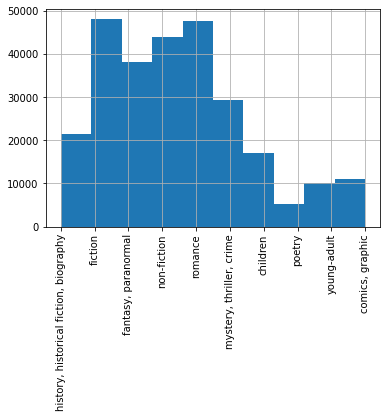

In [218]:
# percent of books where the correct label is equal to one of the predictions
merged_all_for_all[(merged_all_for_all['true_label1'] == merged_all_for_all['nb_desc_predictions']) |(merged_all_for_all['true_label1'] == merged_all_for_all['lstm_predictions']) | (merged_all_for_all['true_label1'] == merged_all_for_all['nb_pred']) | (merged_all_for_all['true_label1'] == merged_all_for_all['logreg_pred']) | (merged_all_for_all['true_label1'] == merged_all_for_all['cover_pred'])]['first'].hist()
plt.xticks(rotation=90)


In [231]:
percent_all_corr = len(merged_all_for_all[(merged_all_for_all['true_label1'] == merged_all_for_all['nb_desc_predictions']) & (merged_all_for_all['true_label1'] == merged_all_for_all['lstm_predictions']) & (merged_all_for_all['true_label1'] == merged_all_for_all['nb_pred']) & (merged_all_for_all['true_label1'] == merged_all_for_all['logreg_pred']) & (merged_all_for_all['true_label1'] == merged_all_for_all['cover_pred'])])/len(merged_all_for_all)
percent_nb_desc_only = len(merged_all_for_all[(merged_all_for_all['true_label1'] == merged_all_for_all['nb_desc_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['lstm_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['nb_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['logreg_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['cover_pred'])])/len(merged_all_for_all)
percent_lstm_only = len(merged_all_for_all[(merged_all_for_all['true_label1'] != merged_all_for_all['nb_desc_predictions']) & (merged_all_for_all['true_label1'] == merged_all_for_all['lstm_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['nb_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['logreg_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['cover_pred'])])/len(merged_all_for_all)
percent_nb_title_only = len(merged_all_for_all[(merged_all_for_all['true_label1'] != merged_all_for_all['nb_desc_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['lstm_predictions']) & (merged_all_for_all['true_label1'] == merged_all_for_all['nb_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['logreg_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['cover_pred'])])/len(merged_all_for_all)
percent_logreg_only = len(merged_all_for_all[(merged_all_for_all['true_label1'] != merged_all_for_all['nb_desc_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['lstm_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['nb_pred']) & (merged_all_for_all['true_label1'] == merged_all_for_all['logreg_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['cover_pred'])])/len(merged_all_for_all)
percent_cover_only = len(merged_all_for_all[(merged_all_for_all['true_label1'] != merged_all_for_all['nb_desc_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['lstm_predictions']) & (merged_all_for_all['true_label1'] != merged_all_for_all['nb_pred']) & (merged_all_for_all['true_label1'] != merged_all_for_all['logreg_pred']) & (merged_all_for_all['true_label1'] == merged_all_for_all['cover_pred'])])/len(merged_all_for_all)


print("Percent where all predictions are the same", round(percent_all_corr,4)*100, "%")
print("Percent where LSTM on Description is only one correct", round(percent_nb_desc_only,2)*100, "%")
print("Percent where NB on Descriptions is only one correct", round(percent_lstm_only,3)*100, "%")
print("Percent where NB on Title is only one correct", round(percent_nb_title_only,3)*100, "%")
print("Percent where Logistic Regression on Title is only one correct", round(percent_logreg_only,4)*100, "%")
print("Percent where Neural Net on Covers is only one correct", round(percent_cover_only,3)*100, "%")

Percent where all predictions are the same 27.36 %
Percent where LSTM on Description is only one correct 4.0 %
Percent where NB on Descriptions is only one correct 2.1 %
Percent where NB on Title is only one correct 0.6 %
Percent where Logistic Regression on Title is only one correct 1.24 %
Percent where Neural Net on Covers is only one correct 1.6 %


When we only consider books that are predicted by all 5 models, the percent that are incapable of being correctly predicted by an ensemble method decreases to ~94% and is much more evenly distributed. 

We can also see that very few books are only correctly predicted by one model but that over a quarter of books are correctly predicted by all models.

## Model For Data With 5 Predictions

In [197]:
from sklearn.model_selection import train_test_split

ensemble_features = merged_all_for_all[['lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred','nb_desc_predictions']]
ensemble_labels = merged_all_for_all['true_label1']

X_train, X_test, y_train, y_test = train_test_split(ensemble_features, ensemble_labels, test_size=0.2, random_state=42)

In [131]:
# 'lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred', 'nb_desc_predictions'
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_model = xgb.XGBClassifier(verbosity=1, max_depth=2)

optimization_dict = {'eta': [0.008, 0.01, 0.05, 0.1],
                     'n_estimators': [100,200, 300]}

model_all_preds = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1, cv=[(slice(None), slice(None))])

model_all_preds.fit(X_train, y_train)
print(model_all_preds.best_score_)
print(model_all_preds.best_params_)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
0.8340259684330656
{'eta': 0.008, 'n_estimators': 300}


In [198]:
#'lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred','nb_desc_predictions'
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold


model_all_preds = xgb.XGBClassifier(verbosity=1, max_depth=2, eta=0.008, n_estimators= 300)
model_all_preds.fit(X_train, y_train)
print(model_all_preds.score(X_test, y_test))  


0.8339936608557845


In [199]:
from sklearn.metrics import classification_report

test_pred = model_all_preds.predict(X_test)

list_of_genres = list(genre_encoding_lookup_df.sort_values(by=['true_label'])['true_genre'])
print(classification_report(y_test, test_pred, target_names=list_of_genres))

                                        precision    recall  f1-score   support

                              children       0.85      0.88      0.86      3528
                       comics, graphic       0.89      0.89      0.89      2187
                   fantasy, paranormal       0.83      0.87      0.85      7735
                               fiction       0.79      0.73      0.76     12015
history, historical fiction, biography       0.77      0.70      0.73      4491
              mystery, thriller, crime       0.86      0.86      0.86      6009
                           non-fiction       0.87      0.89      0.88      9046
                                poetry       0.90      0.92      0.91      1104
                               romance       0.85      0.89      0.87      9870
                           young-adult       0.79      0.83      0.81      2067

                              accuracy                           0.83     58052
                             macro avg

In [234]:
#'lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred','nb_desc_predictions'

lstm_acc = len(merged_all_for_all[merged_all_for_all['lstm_predictions'] == merged_all_for_all['true_label1']])/len(merged_all_for_all)
nb_desc_acc = len(merged_all_for_all[merged_all_for_all['nb_desc_predictions'] == merged_all_for_all['true_label1']])/len(merged_all_for_all)
nb_title_acc = len(merged_all_for_all[merged_all_for_all['nb_pred'] == merged_all_for_all['true_label1']])/len(merged_all_for_all)
logreg_acc = len(merged_all_for_all[merged_all_for_all['logreg_pred'] == merged_all_for_all['true_label1']])/len(merged_all_for_all)
cover_acc = len(merged_all_for_all[merged_all_for_all['cover_pred'] == merged_all_for_all['true_label1']])/len(merged_all_for_all)

print("Percent accuracy LSTM on Descriptions", round(lstm_acc,4)*100, "%")
print("Percent accuracy NB on Descriptions", round(nb_desc_acc,4)*100, "%")
print("Percent accuracy NB on Title", round(nb_title_acc,4)*100, "%")
print("Percent accuracy Logistic Regression on Title", round(logreg_acc,4)*100, "%")
print("Percent accuracy Neural Net on Covers", round(cover_acc,4)*100, "%")

Percent accuracy LSTM on Descriptions 69.83 %
Percent accuracy NB on Descriptions 72.36 %
Percent accuracy NB on Title 69.1 %
Percent accuracy Logistic Regression on Title 72.11 %
Percent accuracy Neural Net on Covers 44.87 %


When using data that has predictions from all 5 models, we can see that the ensemble method performs well above the best base model, with over a 10% increase. 

## Model for All Data


In [136]:
from sklearn.model_selection import train_test_split

ensemble_features = merged_all[['lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred', 'nb_desc_predictions']]
ensemble_labels = merged_all['true_label1']

X_train, X_test, y_train, y_test = train_test_split(ensemble_features, ensemble_labels, test_size=0.2, random_state=42)

In [139]:
# 2 hrs
# 'lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred', 'nb_desc_predictions'
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_model = xgb.XGBClassifier(verbosity=1, max_depth=2)

optimization_dict = {'eta': [0.008, 0.01, 0.05, 0.1],
                     'n_estimators': [100, 200, 300]}

model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1, cv=[(slice(None), slice(None))])

model.fit(X_train, y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
0.8034131285524828
{'eta': 0.008, 'n_estimators': 300}


In [140]:
#18 min
# 'lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred', 'nb_desc_predictions'
model = xgb.XGBClassifier(verbosity=1, max_depth=2, eta=0.008, n_estimators= 300)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))  

0.8034752293829821


In [195]:
from sklearn.metrics import classification_report

test_pred = model.predict(X_test)

list_of_genres = list(genre_encoding_lookup_df.sort_values(by=['true_label'])['true_genre'])
print(classification_report(y_test, test_pred, target_names=list_of_genres))

                                        precision    recall  f1-score   support

                              children       0.79      0.85      0.82     19094
                       comics, graphic       0.86      0.88      0.87     11903
                   fantasy, paranormal       0.80      0.83      0.82     32571
                               fiction       0.76      0.70      0.73     59464
history, historical fiction, biography       0.74      0.71      0.72     27613
              mystery, thriller, crime       0.82      0.84      0.83     28789
                           non-fiction       0.85      0.85      0.85     53772
                                poetry       0.84      0.90      0.87      6437
                               romance       0.82      0.85      0.84     43479
                           young-adult       0.74      0.77      0.76      8312

                              accuracy                           0.80    291434
                             macro avg

In [237]:
#'lstm_predictions', 'nb_pred', 'logreg_pred', 'cover_pred','nb_desc_predictions'

lstm_acc = len(merged_all[merged_all['lstm_predictions'] == merged_all['true_label1']])/len(merged_all)
nb_desc_acc = len(merged_all[merged_all['nb_desc_predictions'] == merged_all['true_label1']])/len(merged_all)
nb_title_acc = len(merged_all[merged_all['nb_pred'] == merged_all['true_label1']])/len(merged_all)
logreg_acc = len(merged_all[merged_all['logreg_pred'] == merged_all['true_label1']])/len(merged_all)
cover_acc = len(merged_all[merged_all['cover_pred'] == merged_all['true_label1']])/len(merged_all)

print("Percent accuracy LSTM on Descriptions", round(lstm_acc,2)*100, "%")
print("Percent accuracy NB on Descriptions", round(nb_desc_acc,3)*100, "%")
print("Percent accuracy NB on Title", round(nb_title_acc,4)*100, "%")
print("Percent accuracy Logistic Regression on Title", round(logreg_acc,4)*100, "%")
print("Percent accuracy Neural Net on Covers", round(cover_acc,4)*100, "%")

Percent accuracy LSTM on Descriptions 59.0 %
Percent accuracy NB on Descriptions 60.9 %
Percent accuracy NB on Title 68.97 %
Percent accuracy Logistic Regression on Title 71.77 %
Percent accuracy Neural Net on Covers 9.64 %


When considering books that don't necessarily have all 5 predictions, we can see that ensembling has still improved accuracy by over 8%.